In [112]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, QTable
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData
from photutils.detection import DAOStarFinder, find_peaks
from photutils.psf import extract_stars, EPSFBuilder, PSFPhotometry
import os


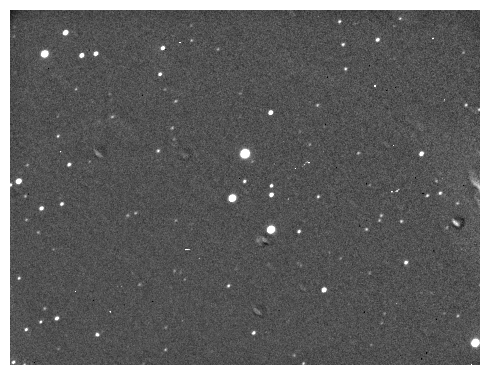

In [3]:
# Load in the image data
data_dir = '../data/2024-04-15/reduced_images/RRGEMINORUM/'
image_list = os.listdir(data_dir)
image_data = fits.getdata(os.path.join(data_dir, image_list[0]))

# Plot the single image
plt.figure(figsize=(5,5), tight_layout=True)

plt.imshow(image_data, origin='lower', cmap='gray', norm=ImageNormalize(image_data, interval=ZScaleInterval()))
plt.axis('off')
plt.show()

,id,x_peak,y_peak,peak_value
0,1,1107,50,65902.919689
1,2,82,736,63901.014093
2,3,557,500,61647.286280
3,4,619,318,60725.112276
4,5,529,395,60003.427415


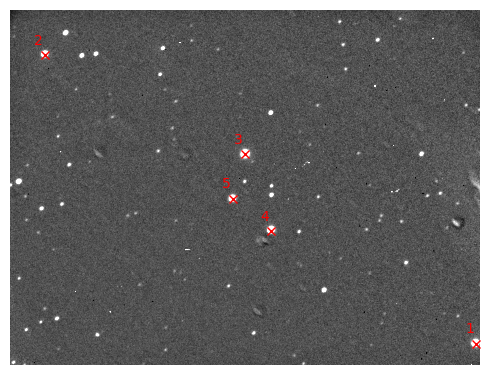

In [7]:
# Calculate the mean, median, and stddev of the image
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)

# Find sources in the image using peak_finder()
tbl = find_peaks(image_data, threshold=median + (5.0 * std), box_size=11).to_pandas().sort_values(by='peak_value', ascending=False).iloc[:5].reset_index(drop=True)

# Re-name the ID of the stars based on the new index
tbl['id'] = tbl.index + 1
display(tbl)
# Plot the single image
plt.figure(figsize=(5,5), tight_layout=True)

plt.imshow(image_data, origin='lower', cmap='gray', norm=ImageNormalize(image_data, interval=ZScaleInterval()))
plt.plot(tbl['x_peak'], tbl['y_peak'], 'rx', lw=0.5)

for i, id in enumerate(tbl['id']):
    plt.text(tbl['x_peak'].iloc[i] - 25, tbl['y_peak'].iloc[i] + 25, id, color='r')
plt.axis('off')
plt.show()

id,group_id,group_size,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,x_err,y_err,flux_err,npixfit,qfit,cfit,flags
int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,int32
1,1,1,0.0,557.0,500.0,61647.2862802912,557.4646559881913,500.6707199599468,4382251.22378489,0.003378880259676039,0.0005488256803969937,66084.62041671184,625,0.4085694919799304,-0.0026723676476697864,0
2,2,1,0.0,619.0,318.0,60725.1122758592,616.3469987587408,318.92507858368185,-86294.69397867551,0.5036472587946619,0.8087198238460157,35232.79771997871,625,-39.41204720616534,-0.6883802668908843,4
3,3,1,0.0,529.0,395.0,60003.42741487018,530.1320873134304,396.17062857535666,1244807.8116622136,0.021919954638012093,0.0031759912934261184,39638.06592745207,625,1.5316301666203291,-0.0020782723768345713,0


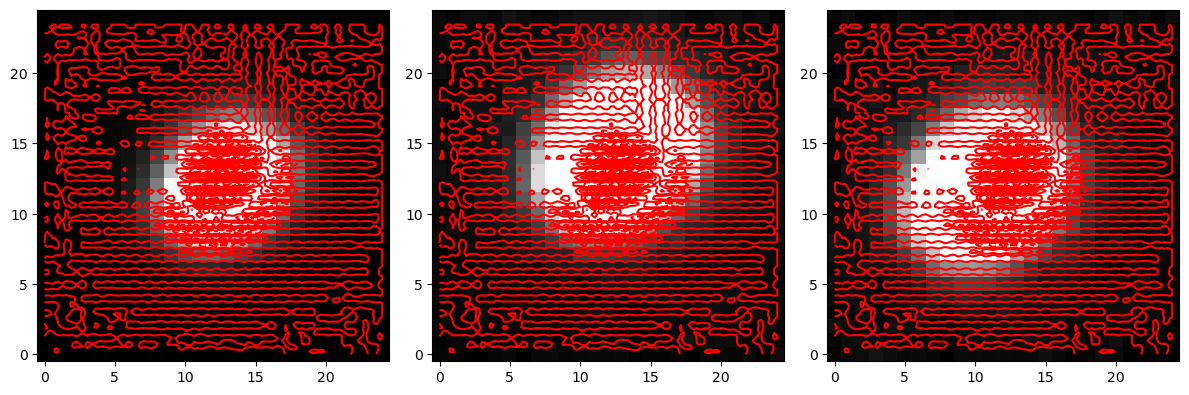

In [13]:
# Select the stars we are going to analyze
stars_peaks = tbl[tbl['id'].isin([3,4,5])]

# Convert the image data to a NDData product
image_nddata = NDData(data=image_data)

# Isolate the stars in the image
isolated_stars = extract_stars(image_nddata, Table(data=stars_peaks[['id','x_peak','y_peak']].values, names=['id','x','y']), size=25) 

# Build the ePSF
epsf_builder = EPSFBuilder(oversampling=5, maxiters=20, progress_bar=False)
epsf, fitted_stars = epsf_builder(isolated_stars)

# Perform PSF photometry
psf_photometry = PSFPhotometry(psf_model=epsf, fit_shape=(25,25))
photometry_results = psf_photometry(image_data, init_params=QTable(data=stars_peaks[['x_peak','y_peak','peak_value']].values, names=['x','y','flux']))

display(photometry_results)

fig, ax = plt.subplots(1,isolated_stars.n_stars, figsize=(12, 4), tight_layout=True)

for i in range(isolated_stars.n_stars):
    model_image = epsf.data
    x_peak, y_peak = isolated_stars.cutout_center_flat[i][1], isolated_stars.cutout_center_flat[i][0]
    
    ax[i].imshow(isolated_stars[i].data, origin='lower', cmap='gray', norm=ImageNormalize(isolated_stars[i].data, interval=ZScaleInterval()))
    ax[i].contour(model_image, extent=(x_peak - 25 // 2, x_peak + 25 // 2,
                                  y_peak - 25 // 2, y_peak + 25 // 2), 
                levels=10, colors='red')

61647.2862802912
60725.1122758592
60003.42741487018


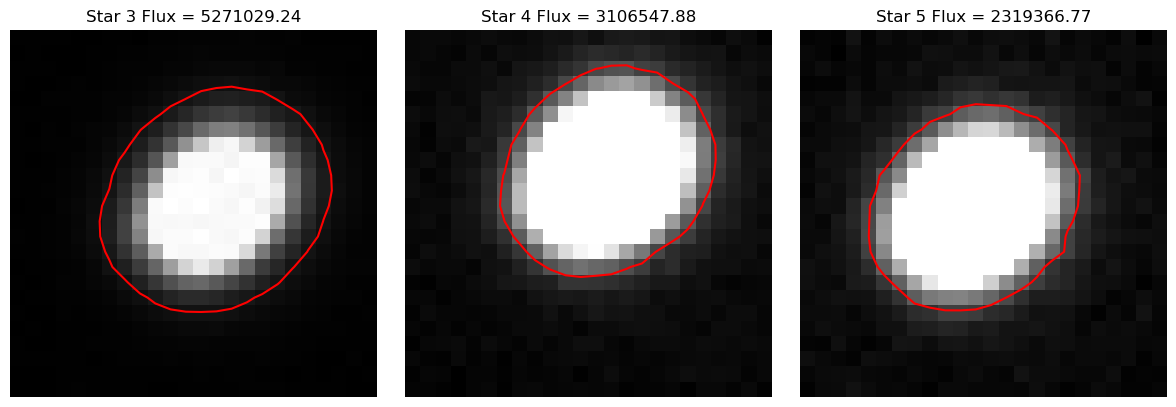

In [87]:
# Generate a manual PSF based on the cutout region
# Define the width and height of the star's cutout regions
width, height = 25, 25

# Define the figure to be plotted
fig, ax = plt.subplots(1,stars_peaks['id'].size, figsize=(12, 4), tight_layout=True)

# Interpolate over the star peaks to create the cutout and calculate the psf photometry
for i, (id, yc, xc) in enumerate(stars_peaks[['id','x_peak','y_peak']].values):

    # Create the cutout for each star
    star_cutout = image_data[xc - height//2:xc + height//2, yc - width//2:yc + width//2]

    # Calculate the mean, median, and stddev of the cutout image
    co_mean, co_median, co_std = sigma_clipped_stats(star_cutout, sigma=3.0)

    # Calculate the total flux of the star around the PSF region
    flux_out = star_cutout[star_cutout > 3*co_std].sum()

    print(star_cutout[star_cutout > 3*co_std].max())

    ax[i].set_title(f"Star {id} Flux = {flux_out.round(2)}")
    ax[i].contour(star_cutout, levels=[3*co_std], colors=['r'])
    ax[i].imshow(star_cutout, origin='lower', cmap='gray', norm=ImageNormalize(star_cutout, interval=ZScaleInterval()))

    ax[i].axis('off')
    
plt.show()

In [89]:
dir(isolated_stars)

['__class__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_data',
 '_getattr_flat',
 '_max_shape',
 'all_good_stars',
 'all_stars',
 'center_flat',
 'cutout_center_flat',
 'n_all_stars',
 'n_good_stars',
 'n_stars']

In [ ]:
# Generate a manual PSF based on the cutout region and the ePSF
# Define the width and height of the star's cutout regions
width, height = 25, 25

# Define the figure to be plotted
fig, ax = plt.subplots(1,stars_peaks['id'].size, figsize=(12, 4), tight_layout=True)

# Interpolate over the star peaks to create the cutout and calculate the psf photometry
for i, (id, yc, xc) in enumerate(stars_peaks[['id','x_peak','y_peak']].values):

    # Create the cutout for each star
    star_cutout = image_data[xc - height//2:xc + height//2, yc - width//2:yc + width//2]

    

In [138]:
full_set = np.arange(16433)[:16400]
train_size = full_set.size * 0.8
valid_size = full_set.size - train_size
batch_size = 82

train_size, valid_size, train_size/batch_size, valid_size/batch_size

(13120.0, 3280.0, 160.0, 40.0)